<a href="https://colab.research.google.com/github/rihat99/openai_gym/blob/main/acrobot_1_DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

env = gym.make('Acrobot-v1')
# tf.random.set_seed(42)
# np.random.seed(42)
# env.seed(42)
print(tf.__version__)
print(gym.__version__)

2.4.1
0.17.3


In [2]:
num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space
print("Size of Action Space ->  {}".format(num_actions))
num_actions = 3

# upper_bound = env.action_space.high[0]
# lower_bound = env.action_space.low[0]

# print("Max Value of Action ->  {}".format(upper_bound))
# print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  6
Size of Action Space ->  Discrete(3)


In [3]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    #last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states))
    out = layers.Dense(128, activation="elu")(inputs)
    out = layers.Dense(128, activation="elu")(out)
    outputs = layers.Dense(num_actions, activation="softmax")(out)

    # Our upper bound is 2.0 for Pendulum.
    #outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(32, activation="elu")(state_input)
    state_out = layers.Dense(64, activation="elu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(64, activation="elu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(128, activation="elu")(concat)
    out = layers.Dense(128, activation="elu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [5]:
from collections import deque
import sys

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.done_buffer = np.zeros((self.buffer_capacity, 1))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.done_buffer[index] = obs_tuple[4]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch, done_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            #target_actions = tf.reduce_max(target_actions, axis=1)
            y = reward_batch + (1-done_batch) * gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            #actions = tf.reduce_max(actions, axis=1)
            critic_value = critic_model([state_batch, actions], training=True)
            #critic_value = tf.squeeze(critic_value)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables))

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        done_batch = tf.convert_to_tensor(self.done_buffer[batch_indices])
        done_batch = tf.cast(done_batch, dtype=tf.float32)

        self.update(state_batch, action_batch, reward_batch, next_state_batch, done_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [6]:
def policy(state, noise_object, epsilon=0):
    sampled_actions = actor_model(state)[0]
    noise = noise_object()
    #sampled_actions = sampled_actions.numpy() + noise
    #legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    if np.random.rand() < epsilon:
        return np.random.randint(num_actions), sampled_actions
    action = np.random.choice(num_actions, p=np.squeeze(sampled_actions))
    #return [np.squeeze(legal_action)]
    return action, sampled_actions



In [7]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005
epsilon = 1.0

buffer = Buffer(100000, 64)

from IPython.display import clear_output

Episode: 999 Current Reward: -176.0
Average_reward:  -155.775


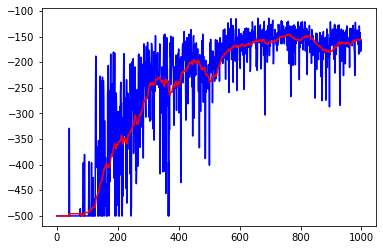

In [8]:
ep_reward_list = []
avg_reward_list = []
best_score = -200
best_weights = actor_model.get_weights()

for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action, sampled_actions = policy(tf_prev_state, ou_noise, epsilon)
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, sampled_actions, reward, state, done))
        episodic_reward += reward
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        if done:
            epsilon = max(0.001, epsilon*0.993)
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)
    clear_output(wait=True)
    print('Episode:', ep, 'Current Reward:', episodic_reward)
    print('Average_reward: ', avg_reward)
    if avg_reward > best_score:
        best_weights = actor_model.get_weights()
        best_score = avg_reward
    plt.plot(np.arange(len(ep_reward_list)),ep_reward_list, 'b',
             np.arange(len(avg_reward_list)), avg_reward_list, 'r')
    plt.show()
    

In [ ]:
actor_model.save("MountainCarContinuous")

INFO:tensorflow:Assets written to: MountainCarContinuous/assets


In [ ]:
reconstructed_model = keras.models.load_model('MountainCarContinuous')

def smart_policy(obs):
    action_prob = reconstructed_model(obs[np.newaxis])
    legal_action = np.clip(action_prob[0], lower_bound, upper_bound)
    return legal_action

totals = []
for episode in range(100):
    episode_reward = 0
    obs = env.reset()
    for step in range(200):
        action = smart_policy(obs)
        obs, reward, done, info = env.step(action)
        #env.render()
        episode_reward += reward
        if done:
            break
    totals.append(episode_reward)

env.close()

import numpy as np
print(np.mean(totals), np.std(totals), np.min(totals), np.max(totals))
#print(totals)

93.4443126922632 0.029127116190577614 93.34364161008428 93.48930569495236


In [ ]:
a = np.array([1.0, 2.0, 3.0])
b = a + 0.01
print(b)

[1.01 2.01 3.01]
